# Mandatory assignment 3

Name: Marie Klever

Using machine learning to predict wich passangers survived the Titanic shipwreck.

### Assignment expectations

- imputation: anything from the simplest tricks in scikit-learn to exploiting the structure of the data to create more tailored solutions,

- pre-processing: typically scaling and OneHots, possibly combining features,
    
- modelling and prediction: use tools from Chapter 6 to select classifier(s) and tune parameters, include tricks from Chapter 7 if you like to, or find external classifiers that can be included in the same framework, e.g. XGBoost

## Loading an analyzing data

Loading libraries and the dataset to be used in the assignment.

### Loading data

In [1]:
%matplotlib inline 

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import VarianceThreshold, RFE, SelectFromModel

# Classification algorithms
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron, LogisticRegression

sns.set_style("whitegrid")

In [2]:
train_data = pd.read_csv("train.csv") # has one more column (survived-column)
test_data = pd.read_csv("test.csv")

In [3]:
print('Train dataset: %s, Test dataset %s' %(str(train_data.shape), str(test_data.shape)))

Train dataset: (891, 12), Test dataset (418, 11)


In [4]:
train_data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [5]:
train_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

### Analyzing data

Looking for missing data (NaN) and where they are.

In [6]:
nans = pd.concat([train_data.isnull().sum(), test_data.isnull().sum()], axis=1, 
                 keys=["Training data", "Test data"]) 
print("There are NaN values in the following feature columns\n")
print(nans[nans.sum(axis=1) > 0])

There are NaN values in the following feature columns

          Training data  Test data
Age                 177       86.0
Cabin               687      327.0
Embarked              2        0.0
Fare                  0        1.0


In [7]:
train_data.describe(include="number")

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

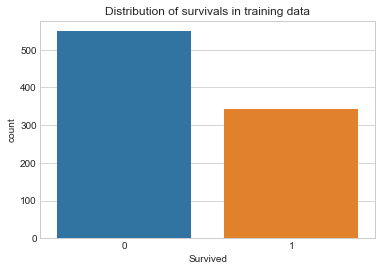

In [8]:
sns.countplot(x="Survived", data=train_data)
plt.title("Distribution of survivals in training data")
plt.show()

Looking at the distribution of the numerical columns using box plots. The green triangle shows the mean value:

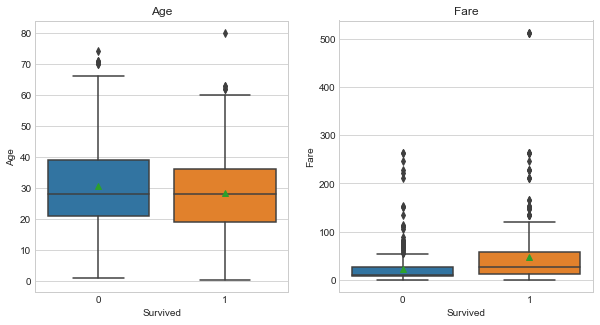

In [9]:
f, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(x="Survived", y="Age", data=train_data, showmeans=True, ax=axes[0]).set_title("Age")
sns.boxplot(x="Survived", y="Fare", data=train_data, showmeans=True, ax=axes[1]).set_title("Fare")
plt.show()

Looking at the distribution of the some of the object columns:

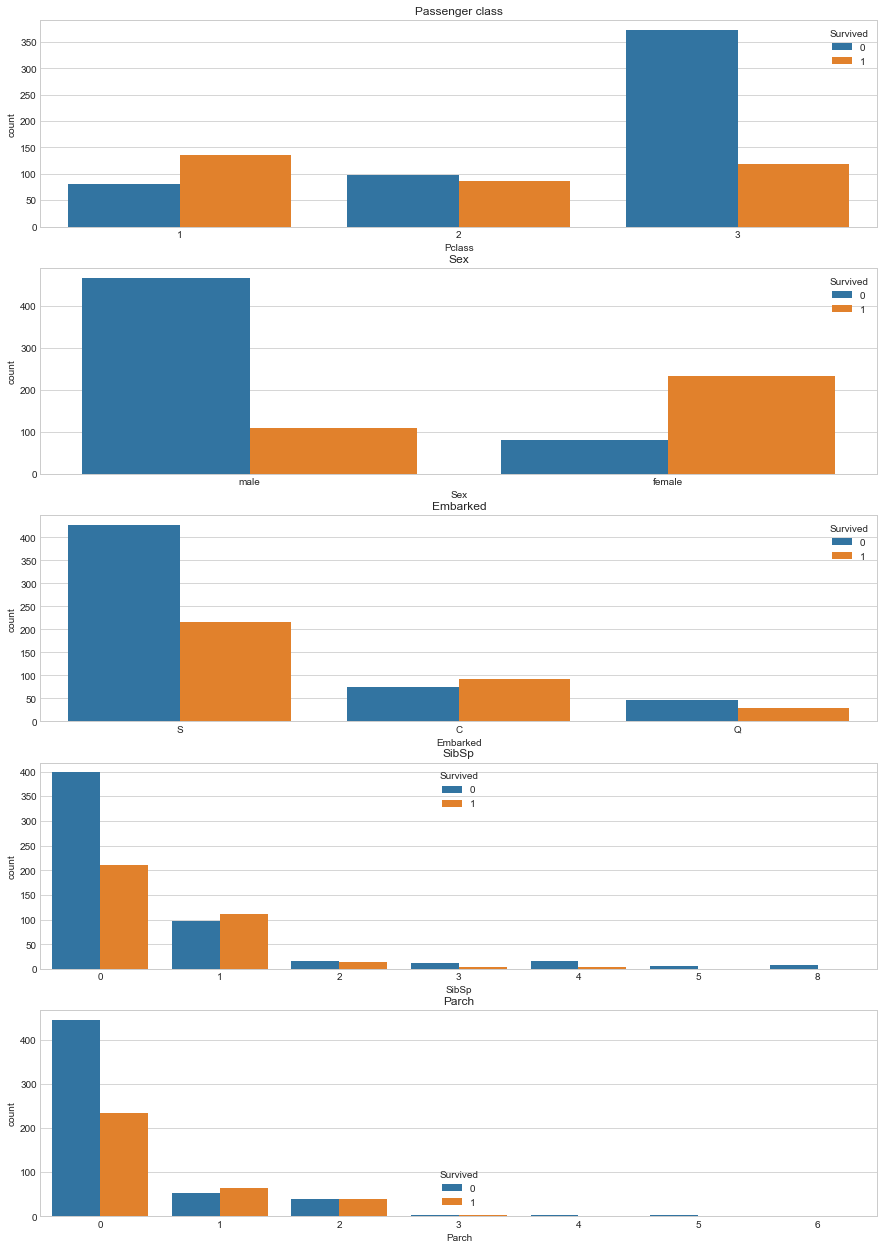

In [11]:
f1, axes = plt.subplots(5, figsize=(15, 22))

sns.countplot(x="Pclass", hue="Survived", data=train_data, ax=axes[0]).set_title("Passenger class")
sns.countplot(x="Sex", hue="Survived", data=train_data, ax=axes[1]).set_title("Sex")
sns.countplot(x="Embarked", hue="Survived", data=train_data, ax=axes[2]).set_title("Embarked")
sns.countplot(x="SibSp", hue="Survived", data=train_data, ax=axes[3]).set_title("SibSp")
sns.countplot(x="Parch", hue="Survived", data=train_data, ax=axes[4]).set_title("Parch")

plt.show()

## Data preprocessing
Cleaning the datasets, filling in NaN values and deleting columns that are not needed.


In [12]:
train_data_copy = train_data.copy()
test_data_copy = test_data.copy()

dataset = train_data_copy.append(test_data_copy, ignore_index=True)

### Missing values

In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [14]:
dataset["Title"] = dataset.Name.str.extract(" ([A-Za-z]+)\.", expand=False)
print(dataset.Title.value_counts())

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Ms            2
Mlle          2
Major         2
Jonkheer      1
Countess      1
Don           1
Mme           1
Capt          1
Lady          1
Sir           1
Dona          1
Name: Title, dtype: int64


In [15]:
# Title feature: adding title feature and remove name ("Mr", "Miss", "Mrs", "Master", "Officer", "Adel")
dataset.Title = dataset.Title.replace(["Capt", "Col", "Major", "Dr", "Rev"], "Officer")
dataset.Title = dataset.Title.replace(["Jonkheer", "Don", "Sir", "Countess", "Dona", "Lady"], "Adel")
dataset.Title = dataset.Title.replace(["Mlle", "Ms"], "Miss")
dataset.Title = dataset.Title.replace(["Mme"], "Mrs")

# Missing ages: the median age value for their gender and pclass (evt. median age for the title)
# Group data by sex, pclass and title
grouped = dataset.groupby(["Sex","Pclass", "Title"])
dataset.Age = grouped.Age.apply(lambda x: x.fillna(x.median()))
    
# Missing Embarked: most occured value
dataset.Embarked = dataset.Embarked.fillna(dataset.Embarked.mode()[0])

# Missing Cabin: applying 0 for missing cabin and 1 for cabin
dataset.Cabin = dataset.Cabin.apply(lambda x: 0 if type(x) == float else 1)    
   
# Missing Fare: median value
dataset.Fare = dataset.Fare.fillna(dataset.Fare.median()) 

In [16]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
Age            1309 non-null float64
Cabin          1309 non-null int64
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Title          1309 non-null object
dtypes: float64(3), int64(5), object(5)
memory usage: 133.0+ KB


### Adding featues


In [17]:
dataset["FamilySize"] = dataset.SibSp + dataset.Parch + 1

dataset["Alone"] = 0
dataset.loc[dataset["FamilySize"] == 1, "Alone"] = 1
    
#dataset["FamilySizeGroup"] = "Small"                                 # 1 < x < 5
#dataset.loc[dataset["FamilySize"] == 1, "FamilySizeGroup"] = "Alone" # 1
#dataset.loc[dataset["FamilySize"] >= 5, "FamilySizeGroup"] = "Big"   # >= 5
    
# First letter of the Cabin

In [18]:
dataset.describe(include="number")

Age        Cabin         Fare        Parch  PassengerId  \
count  1309.000000  1309.000000  1309.000000  1309.000000  1309.000000   
mean     29.268655     0.225363    33.281086     0.385027   655.000000   
std      13.450246     0.417981    51.741500     0.865560   378.020061   
min       0.170000     0.000000     0.000000     0.000000     1.000000   
25%      21.000000     0.000000     7.895800     0.000000   328.000000   
50%      26.000000     0.000000    14.454200     0.000000   655.000000   
75%      36.500000     0.000000    31.275000     0.000000   982.000000   
max      80.000000     1.000000   512.329200     9.000000  1309.000000   

            Pclass        SibSp    Survived   FamilySize        Alone  
count  1309.000000  1309.000000  891.000000  1309.000000  1309.000000  
mean      2.294882     0.498854    0.383838     1.883881     0.603514  
std       0.837836     1.041658    0.486592     1.583639     0.489354  
min       1.000000     0.000000    0.000000     1.000000     0.000000  
25%       2.000000     0.000000    0.000000     1.000000     0.000000  
50%       3.000000     0.000000    0.000000     1.000000     1.000000  
75%       3.000000     1.000000    1.000000     2.000000     1.000000  
max       3.000000     8.000000    1.000000    11.000000     1.000000

### Encoding categorical values and feature selection

Encoding categorical/object features to numerical values.

In [21]:
# Create dummy variables for categorical features
# Dropping the following: "Name", "Ticket", "SibSp", "Parch"
  
dataset_num = dataset.loc[:, ["Age", "Cabin", "Fare", "Survived", "Alone", "FamilySize", "PassengerId"]]
dataset.Pclass = dataset.Pclass.astype("object")
dataset_dummy = dataset.loc[:, ["Title", "Embarked", "Pclass", "Sex"]]

dummies = pd.get_dummies(dataset_dummy, drop_first=True)
dataset_ny = dataset_num.join(dummies)

print("Preprocessed data shape: {}".format(dataset_ny.shape))

Preprocessed data shape: (1309, 17)


In [ ]:
# I can do this if I want to later (not included)

# Fare: mapped to 4 values (0/1/2/3)
dataset.loc[dataset.Fare <= 7.9, "Fare"] = 0
dataset.loc[dataset.Fare > 7.9, "Fare"] & dataset.loc[dataset.Fare <= 14.45, "Fare"] = 1
dataset.loc[dataset.Fare > 14.45, "Fare"] & dataset.loc[dataset.Fare <= 31.27, "Fare"] = 2
dataset.loc[dataset.Fare > 31.27, "Fare"] = 3
    
# Age: mapping ages to bins based on the above box plot numbers
dataset.loc[dataset.Age <= 21, "Age"] = 0
dataset.loc[dataset.Age > 21, "Age"] & dataset.loc[dataset.Age <= 26, "Age"] = 1
dataset.loc[dataset.Age > 26, "Age"] & dataset.loc[dataset.Age <= 36.5, "Age"] = 2
dataset.loc[dataset.Age > 36.5, "Age"] = 3

## Modeling and evaluating different classifiers

Creating the finale datasets to work with in the following section.

In [59]:
test_data_index = dataset_ny.Survived.isnull()

X_train = dataset_ny[~test_data_index]
y_train = X_train.Survived
X_train = X_train.drop("Survived", axis=1)
X_test = dataset_ny[test_data_index]
X_test = X_test.drop("Survived", axis=1)

print("The final shapes of the data are: X_train %s, y_train %s and X_test %s" 
      %(str(X_train.shape), str(y_train.shape), str(X_test.shape)))

The final shapes of the data are: X_train (891, 16), y_train (891,) and X_test (418, 16)


In [60]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [61]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size=0.3, random_state=42, 
                                                       stratify=y_train)

Random Forest Classifier

In [62]:
pipe_rf = Pipeline([("scl", StandardScaler()), ("clf", RandomForestClassifier())])
params_rf = { "clf__max_depth": [x for x in range(9,14)],
              "clf__min_samples_split": [x for x in range(4, 11)],
              "clf__min_samples_leaf": [x for x in range(2,5)],
              "clf__n_estimators": [x for x in range(10, 60, 10)]}

gridsearch_rf = GridSearchCV(pipe_rf, params_rf, cv=10)
gridsearch_rf.fit(X_train1, y_train1)

print('Best training accuracy: %.3f' % gridsearch_rf.best_score_)
y_pred = gridsearch_rf.best_estimator_.predict(X_test1)
print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test1, y_pred))
print("Optimal params: {}".format(gridsearch_rf.best_estimator_))

Best training accuracy: 0.848
Test set accuracy score for best params: 0.813 
Optimal params: Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=13, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
          ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])


Decision Tree Classifier

In [63]:
pipe_dt = Pipeline([("scl", StandardScaler()), ("clf", DecisionTreeClassifier())])
params_dt = { "clf__max_depth": [x for x in range(1,100)]}

gridsearch_dt = GridSearchCV(pipe_dt, params_dt, cv=10)
gridsearch_dt.fit(X_train1, y_train1)

print('Best training accuracy: %.3f' % gridsearch_dt.best_score_)
y_pred_dt = gridsearch_dt.best_estimator_.predict(X_test1)
print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test1, y_pred_dt))
print("Optimal params: {}".format(gridsearch_dt.best_estimator_))

Best training accuracy: 0.817
Test set accuracy score for best params: 0.817 
Optimal params: Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])


K nearest neighbour classifier

In [64]:
pipe_knn = Pipeline([("scl", StandardScaler()), ("clf", KNeighborsClassifier())])
params_knn = { "clf__n_neighbors": [x for x in range(1, 9)], 
              "clf__p": [x for x in range(2, 8)]}

gridsearch_knn = GridSearchCV(pipe_knn, params_knn, cv=10)
gridsearch_knn.fit(X_train1, y_train1)

print('Best training accuracy: %.3f' % gridsearch_knn.best_score_)
y_pred_knn = gridsearch_knn.best_estimator_.predict(X_test1)
print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test1, y_pred_knn))
print("Optimal params: {}".format(gridsearch_knn.best_estimator_))

Best training accuracy: 0.820
Test set accuracy score for best params: 0.806 
Optimal params: Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=4,
           weights='uniform'))])


Logistic Regression classifier

In [65]:
pipe_lr = Pipeline([("scl", StandardScaler()), ("clf", LogisticRegression())])
params_lr = { "clf__C": [0.01, 0.05, 0.1, 0.5, 1],
             "clf__penalty": ["l1", "l2"]}

gridsearch_lr = GridSearchCV(pipe_lr, params_lr, cv=10)
gridsearch_lr.fit(X_train1, y_train1)

print('Best training accuracy: %.3f' % gridsearch_lr.best_score_)
y_pred_lr = gridsearch_lr.best_estimator_.predict(X_test1)
print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test1, y_pred_lr))
print("Optimal params: {}".format(gridsearch_lr.best_estimator_))

Best training accuracy: 0.830
Test set accuracy score for best params: 0.825 
Optimal params: Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


Linear SVC classifier

In [66]:
pipe_lsvc = Pipeline([("scl", StandardScaler()), ("clf", LinearSVC())])
params_lsvc = { "clf__C": [0.01, 0.05, 0.1, 0.5, 1]}

gridsearch_lsvc = GridSearchCV(pipe_lsvc, params_lsvc, cv=10)
gridsearch_lsvc.fit(X_train1, y_train1)

print('Best training accuracy: %.3f' % gridsearch_lsvc.best_score_)
y_pred_lsvc = gridsearch_lsvc.best_estimator_.predict(X_test1)
print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test1, y_pred_lsvc))
print("Optimal params: {}".format(gridsearch_lsvc.best_estimator_))

Best training accuracy: 0.836
Test set accuracy score for best params: 0.836 
Optimal params: Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])


SVC classifier

In [67]:
pipe_svc = Pipeline([("scl", StandardScaler()), ("clf", SVC())])
params_svc = { "clf__C": [0.01, 0.05, 0.1, 0.5, 1]}

gridsearch_svc = GridSearchCV(pipe_svc, params_svc, cv=10)
gridsearch_svc.fit(X_train1, y_train1)

print('Best training accuracy: %.3f' % gridsearch_svc.best_score_)
y_pred_svc = gridsearch_svc.best_estimator_.predict(X_test1)
print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test1, y_pred_svc))
print("Optimal params: {}".format(gridsearch_svc.best_estimator_))

Best training accuracy: 0.838
Test set accuracy score for best params: 0.825 
Optimal params: Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])


Making the final submissions:

In [68]:
preds_rf = gridsearch_rf.best_estimator_.predict(X_test)
submission_rf = pd.DataFrame(data={"PassengerId": X_test.PassengerId, "Survived": preds_rf})
submission_rf.Survived = submission_rf.Survived.astype(int)
submission_rf.to_csv("submission_randForrest.csv",index=False)

In [69]:
preds_dt = gridsearch_dt.best_estimator_.predict(X_test)
submission_dt = pd.DataFrame(data={"PassengerId": X_test.PassengerId, "Survived": preds_dt})
submission_dt.Survived = submission_dt.Survived.astype(int)
submission_dt.to_csv("submission_decTree.csv",index=False)

In [70]:
preds_knn = gridsearch_knn.best_estimator_.predict(X_test)
submission_knn = pd.DataFrame(data={"PassengerId": X_test.PassengerId, "Survived": preds_knn})
submission_knn.Survived = submission_knn.Survived.astype(int)
submission_knn.to_csv("submission_kNearestNeighbor.csv",index=False)

In [71]:
preds_lr = gridsearch_lr.best_estimator_.predict(X_test)
submission_lr = pd.DataFrame(data={"PassengerId": X_test.PassengerId, "Survived": preds_lr})
submission_lr.Survived = submission_lr.Survived.astype(int)
submission_lr.to_csv("submission_logReg.csv",index=False)

In [72]:
preds_lsvc = gridsearch_lsvc.best_estimator_.predict(X_test)
submission_lsvc = pd.DataFrame(data={"PassengerId": X_test.PassengerId, "Survived": preds_lsvc})
submission_lsvc.Survived = submission_lsvc.Survived.astype(int)
submission_lsvc.to_csv("submission_linearSVC.csv",index=False)

In [73]:
preds_svc = gridsearch_svc.best_estimator_.predict(X_test)
submission_svc = pd.DataFrame(data={"PassengerId": X_test.PassengerId, "Survived": preds_svc})
submission_svc.Survived = submission_svc.Survived.astype(int)
submission_svc.to_csv("submission_SVC.csv",index=False)